# Загрузка компонентов

In [2]:
import matplotlib
matplotlib.rc('font',**{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex',unicode=True)
matplotlib.rc('text.latex',preamble='\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex',preamble='\usepackage[russian]{babel}')
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

%pylab inline

from collections import defaultdict, Counter

import matplotlib.pyplot as plt
import matplotlib.markers

import numpy
from scipy.stats import randint as sp_randint, expon as sp_expon
from pandas import DataFrame, Series, get_dummies, isnull
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, \
    RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.grid_search import RandomizedSearchCV
from sklearn.svm import LinearSVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn import metrics

Populating the interactive namespace from numpy and matplotlib


In [3]:
def prepare_df_base(df):
    df = get_dummies(df)
    labels = df.columns
    df = df - df.min('rows')
    df = df / df.max('rows')
    return df, labels


def prepare_df_zero(df):
    df, labels = prepare_df_base(df)
    return df.fillna(0).as_matrix(), labels


def count_fill_in_series(series):
    return 1 - sum(1 for x in isnull(series) if x) / float(series.size)


def eval_fill_rate(df):
    return df.apply(count_fill_in_series, axis = 0)


def prepare_df_mean_strip(df, strip_fill_rate = 0.05):
    columns_to_drop = frozenset(col
                                for col, fill_rate
                                in eval_fill_rate(df).iteritems()
                                if fill_rate < strip_fill_rate)
    df = df.drop(columns_to_drop, axis = 1)
    df, _ = prepare_df_base(df)
    return df.fillna(df.mean()).as_matrix(), df.columns

In [4]:
CLS_METRICS = {
    'p' : metrics.precision_score,
    'r' : metrics.recall_score,
    'f1' : metrics.f1_score
}

REG_METRICS = {
    'mae' : metrics.mean_absolute_error,
    'evs' : metrics.explained_variance_score,
    'r2' : metrics.r2_score
}


def sort_dict_print(d):
    for k, v in sorted(d.viewitems(), key = lambda p: -p[1]):
        print '%10.4f\t%s' % (v, k)


def get_features_importance(clf, labels):
    try:
        clf = clf.best_estimator_
    except:
        try:
            clf = clf.get_params(True)['estimator']
        except:
            clf = None
    if clf is None:
        return {}
    try:
        assert len(labels) == len(clf.feature_importances_), "%r %r" % (len(labels), clf.feature_importances_.shape)
        return zip(labels, clf.feature_importances_)
    except Exception as ex:
        raise


def cls_cross_val(X, Y, feature_labels, pipeline, folds_n = 3, metrics = CLS_METRICS):
    result = {}
    features_imp = defaultdict(float)
    labels = list(set(Y))
    if len(labels) > 2:
        labels_ids = { label: i for i, label in enumerate(labels) }
        Y = label_binarize([labels_ids[label] for label in Y],
                           classes = [labels_ids[label] for label in labels])
    else:
        labels_ids = { True: 0 }
        Y = Y.reshape((Y.shape[0], 1))
    for label, label_i in labels_ids.viewitems():
        label_result = []
        label_Y = Y[:, label_i]
        if numpy.sum(label_Y) < folds_n:
            continue
        if folds_n == 1:
            all_idx = range(label_Y.shape[0])
            folds = [(all_idx, all_idx)]
        else:
            folds = StratifiedKFold(label_Y,
                                    n_folds = folds_n,
                                    shuffle = True)
        for train_idx, test_idx in folds:
            X_train, Y_train = X[train_idx], label_Y[train_idx]
            X_test, Y_test = X[test_idx], label_Y[test_idx]
            pipeline.fit(X_train, Y_train)
            for k, v in get_features_importance(pipeline, feature_labels):
                features_imp[k] += v
            Y_pred = pipeline.predict(X_test)
            label_result.append({metric_label : metric_func(Y_test, Y_pred)
                                 for metric_label, metric_func in metrics.viewitems() })
        result[label] = DataFrame(data = label_result).describe()
    result['OVERALL_MACRO_MEAN'] = DataFrame(data = [r.loc['mean']
                                                     for r
                                                     in result.viewvalues()]).describe()
    return result, features_imp

def reg_cross_val(X, Y, feature_labels, pipeline, folds_n = 3, metrics = REG_METRICS):
    result = []
    features_imp = defaultdict(float)
    if folds_n == 1:
        all_idx = range(Y.shape[0])
        folds = [(all_idx, all_idx)]
    else:
        folds = KFold(Y.shape[0], n_folds = folds_n)
    for train_idx, test_idx in folds:
        X_train, Y_train = X[train_idx], Y[train_idx]
        X_test, Y_test = X[test_idx], Y[test_idx]
        pipeline.fit(X_train, Y_train)
        for k, v in get_features_importance(pipeline, feature_labels):
            features_imp[k] += v
        Y_pred = pipeline.predict(X_test)
        print 'append'
        result.append({metric_label : metric_func(Y_test, Y_pred)
                       for metric_label, metric_func in metrics.viewitems() })
    print result
    return DataFrame(result).describe(), features_imp

# Загрузка и подготовка данных

In [5]:
data = DataFrame.from_csv('real_sample.csv')
data

,DTH/Антиген,DTH/Качественное значение,DTH/Количественное значение до иммунизации,DTH/Количественное значение после иммунизации,ELISPOT/Антиген,ELISPOT/Качественное значение,ELISPOT/Количественное значение до иммунизации,ELISPOT/Количественное значение после иммунизации,Адъювант в составе вакцины/Значение,Антиген-специфические лимфоциты in vitro/Антиген,...,Опухолевые маркеры/Количественное значение до вакцинации,Опухолевые маркеры/Количественное значение после вакцинации,Опухолевые маркеры/Тип маркера,Побочные эффекты/Значение,Пол/Значение,Раса/Значение,Сопутствующая терапия/Значение,Способ введения вакцины/Значение,Стадия заболевания/Значение,Тип вакцины/Значение
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Control antigen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Control antigen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Control antigen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tumor antigen,...,NaN,NaN,NaN,Not significant,Male,NaN,Immunotherapy,Intravenously,NaN,Protein
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tumor antigen,...,NaN,NaN,NaN,Not significant,Male,NaN,Immunotherapy,Intravenously,NaN,Protein
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KLH,Control antigen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tumor antigen,...,NaN,NaN,NaN,Not significant,Male,NaN,Immunotherapy,Intravenously,NaN,Protein
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tumor antigen,...,NaN,NaN,NaN,Not significant,Male,NaN,Immunotherapy,Intravenously,NaN,Protein
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tumor antigen,...,NaN,NaN,PSA,Not significant,Male,NaN,Immunotherapy,Intravenously,NaN,Protein
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Control antigen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data.shape

(1549, 46)

In [7]:
for colname in data.columns:
    print "!!!", colname, Counter(data[colname].dropna()).most_common(20)

!!! DTH/Антиген [('-', 139), ('Tumor antigen', 136), ('Control antigen', 43)]
!!! DTH/Качественное значение [('Yes', 182), ('No', 109), ('-', 26), ('Not done', 1)]
!!! DTH/Количественное значение до иммунизации [(5.0, 2), (6.0, 2), (34.0, 1), (8.0, 1), (9.0, 1), (12.0, 1), (13.0, 1), (14.0, 1), (16.0, 1), (17.0, 1)]
!!! DTH/Количественное значение после иммунизации [(7.0, 3), (4.0, 2), (16.0, 2), (1.0, 2), (7.5, 1), (48.0, 1), (3.0, 1), (6.0, 1), (8.0, 1), (9.0, 1), (12.0, 1), (5.7999999999999998, 1), (20.0, 1), (41.0, 1), (28.0, 1)]
!!! ELISPOT/Антиген [('Tumor antigen', 130), ('-', 47), ('Control antigen', 16)]
!!! ELISPOT/Качественное значение [('Yes', 76), ('No', 64), ('-', 48), ('Not done', 5)]
!!! ELISPOT/Количественное значение до иммунизации [(13.0, 2), (1.0, 1), (2.0, 1), (804.0, 1), (37.0, 1), (8.0, 1), (41.0, 1), (266.0, 1), (11.0, 1), (12.0, 1), (109.0, 1), (16.0, 1), (87.0, 1), (249.0, 1)]
!!! ELISPOT/Количественное значение после иммунизации [(2.1499999999999999, 7), (32.

In [8]:
Counter(('cat' if sum(1 for v in data[colname].dropna() if isinstance(v, str)) > 0 else 'num')
        for colname in data.columns if len(set(data[colname].dropna())) > 0).most_common()

[('cat', 25), ('num', 21)]

In [9]:
TREATMENT_OUTCOME_COLUMNS = frozenset(['Объективный клинический ответ/Значение',
                                       'Выживаемость/Единицы измерения',
                                       'Выживаемость/Результат',
                                       'Выживаемость/Срок дожития/наблюдения'])

In [10]:
ST_UNITS_DAYS = { 'Months' : 30, 'Days' : 1, 'Weeks' : 7, 'Years' : 365, '-' : 30 }
Counter(data['Выживаемость/Единицы измерения']).most_common()

[(nan, 910),
 ('Months', 465),
 ('Days', 69),
 ('Weeks', 61),
 ('-', 34),
 ('Years', 10)]

# Оценка частоты встречаемости признаков

RuntimeError: LaTeX was not able to process your file:    
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.14159265-2.6-1.40.16 (MiKTeX 2.9 64-bit)
entering extended mode
! I can't find file `c:/users/aleksa'.
<to be read again> 
                   \protect 
<*> c:/users/aleksa~
                    1/appdata/local/temp/3/tmptydgvp.tex
Please type another input file name
! Emergency stop.
<to be read again> 
                   \protect 
<*> c:/users/aleksa~
                    1/appdata/local/temp/3/tmptydgvp.tex
No pages of output.
Transcript written on texput.log.


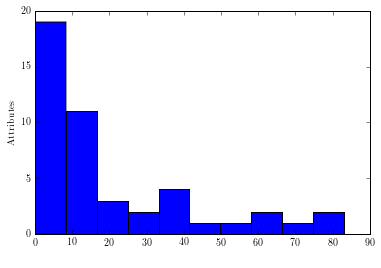

In [11]:
fig, ax = plt.subplots(1)
ax.hist([int(x * 100) for x in eval_fill_rate(data)])
ax.set_ylabel('Attributes')
ax.set_xlabel('of non-null items')
fig.savefig('features-fill-ratio-hist.eps')
fig.show()

In [12]:
for k, v in sorted(eval_fill_rate(data).iteritems(), key = lambda p: -p[1]):
    print k, v

Возраст/Точное значение или медиана (для группы) 0.83279535184
Объективный клинический ответ/Значение 0.772756617172
Пол/Значение 0.71723692705
Лечение до иммунизации/Значение 0.658489347966
Вакцинация/Количество вакцинаций 0.619109102647
Диагноз/Значение 0.578437701743
Вакцинация/Общее количество введенных клеток 0.473208521627
Выживаемость/Единицы измерения 0.412524209167
Выживаемость/Результат 0.412524209167
Выживаемость/Срок дожития/наблюдения 0.408650742414
Стадия заболевания/Значение 0.344738540994
Тип вакцины/Значение 0.275661717237
Побочные эффекты/Значение 0.262104583602
Способ введения вакцины/Значение 0.238218205294
DTH/Антиген 0.205293737895
DTH/Качественное значение 0.205293737895
Источник дендритных клеток/Значение 0.169786959329
Гаплотип/Значение 0.164622336992
Индекс Карновского/Точное значение или медиана (для группы) 0.137508069722
Возраст/ГРУППА: наибольшее значение 0.126533247256
Возраст/ГРУППА: наименьшее значение 0.126533247256
ELISPOT/Антиген 0.12459651388
ELISPO

# Классификация по Объективному клиническому ответу

In [13]:
obj_outcome = data['Объективный клинический ответ/Значение']

missing_outcome = frozenset(('Not evaluable', 'Not applicable', 'Death'))
good_outcome = frozenset(('Partial Response', 'Complete response'))

or_data = data[obj_outcome.apply(lambda el: not (isnull(el) or el in missing_outcome))]

#or_Y = or_data['Объективный клинический ответ/Значение'].apply(lambda el: el in good_outcome).as_matrix()
or_Y = or_data['Объективный клинический ответ/Значение'].as_matrix()
or_X, or_X_labels = prepare_df_mean_strip(or_data.drop(TREATMENT_OUTCOME_COLUMNS, axis = 1))

In [14]:
print "number", len(or_Y)
for k, v in Counter(or_Y).most_common():
    print k, v
print or_X.shape

number 1088
Progressive Disease 463
Stable Desease 300
Partial Response 189
Complete response 136
(1088L, 114L)


In [ ]:
base_clf = RandomForestClassifier()
# base_clf = ExtraTreesClassifier()
params_dist = {
    "max_depth" : [3, 5, 10, 20, None],
    "n_estimators" : [50, 100, 200, 400],
    "min_samples_split" : [2, 4, 6],
    "min_samples_leaf" : [1, 2, 4],
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

# base_clf = GradientBoostingClassifier()
# params_dist = {
#     "learning_rate" : [1e-3, 1e-2, 1e-1, 1],
#     "max_depth" : [3, 5, 10, 20, None],
#     "n_estimators" : [20, 50, 100, 200, 400],
#     "min_samples_split" : [2, 4, 6],
#     "min_samples_leaf" : [1, 2, 4],
#     "subsample" : [1.0, 0.8]
# }

# base_clf = AdaBoostClassifier()
# params_dist = {
#     "learning_rate" : [1e-1, 1, 2, 10],
#     "n_estimators" : [20, 50, 100, 200, 400],
# }

n_sample_iters = 100
optimal_clf = RandomizedSearchCV(base_clf,
                                 params_dist,
                                 scoring = 'f1',
                                 n_iter = n_sample_iters,
                                 n_jobs = -1)
cls_res, cls_features = cls_cross_val(or_X, or_Y, or_X_labels, optimal_clf, folds_n = 3)
for label, res in cls_res.viewitems():
    print label
    print res
    print

In [ ]:
sort_dict_print(cls_features)

# Классификация по порогу выживаемости

In [ ]:
cls_st_data = data[data['Выживаемость/Срок дожития/наблюдения'].fillna(0) != 0]
base_cls_st_Y = cls_st_data[['Выживаемость/Срок дожития/наблюдения', 'Выживаемость/Единицы измерения']].apply(lambda r: r['Выживаемость/Срок дожития/наблюдения'] * ST_UNITS_DAYS[r['Выживаемость/Единицы измерения']],
                                                                                                              axis = 'columns').as_matrix()
cls_st_X, cls_st_X_labels = prepare_df_mean_strip(cls_st_data.drop(TREATMENT_OUTCOME_COLUMNS, axis = 1))
cls_st_X

In [ ]:
base_st_clf = RandomForestClassifier()
st_clf_params_dist = {
    "max_depth" : [3, 5, 10, 20, None],
    "n_estimators" : [50, 100, 200, 400],
    "min_samples_split" : [2, 4, 6],
    "min_samples_leaf" : [1, 2, 4],
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}
st_clf_n_sample_iters = 100
optimal_st_clf = RandomizedSearchCV(base_st_clf,
                                    params_dist,
                                    scoring = 'f1',
                                    n_iter = st_clf_n_sample_iters,
                                    n_jobs = -1)

min_st = base_cls_st_Y.min()
max_st = min(2000, base_cls_st_Y.max())
days_step = 100
days_thresholds = range(int(min_st),
                        int(max_st + days_step / 2),
                        days_step)
days_quality_self = []
days_quality_cv = []
pos_counts = []
days_features_importance = defaultdict(float)
print "evaluating from %d to %d with step %d (%d iterations)" % (days_thresholds[0],
                                                                 days_thresholds[-1],
                                                                 days_step,
                                                                 len(days_thresholds))
for th in days_thresholds:
    print "evaluate over %d days threshold..." % th
    this_th_Y = base_cls_st_Y >= th
    pos_counts.append(float(sum(1 for el in this_th_Y if el)))
    for label, res in cls_cross_val(cls_st_X,
                                    this_th_Y,
                                    cls_st_X_labels,
                                    optimal_st_clf,
                                    folds_n = 1)[0].viewitems():
        if label != True:
            continue
        days_quality_self.append(dict(res.loc['mean']))
    th_cv_res, th_cv_features = cls_cross_val(cls_st_X,
                                              this_th_Y,
                                              cls_st_X_labels,
                                              optimal_st_clf,
                                              folds_n = 3)
    for label, res in th_cv_res.viewitems():
        if label != True:
            continue
        days_quality_cv.append(dict(res.loc['mean']))
    for k, v in th_cv_features.viewitems():
        days_features_importance[k] += v
days_quality_self = DataFrame(data = days_quality_self)
days_quality_cv = DataFrame(data = days_quality_cv)
print "done"

In [ ]:
days_pos_count_fig, days_pos_count_ax = plt.subplots(1)
days_pos_count_ax.plot(days_thresholds, pos_counts)
days_pos_count_ax.set_ylabel('# of positive examples')
days_pos_count_ax.set_xlabel('Survival threshold, days')
days_pos_count_fig.savefig('st-cls-pos-count.eps')
days_pos_count_fig.show()

days_f1_fig, days_f1_ax = plt.subplots(1)
days_f1_ax.plot(days_thresholds, days_quality_self['f1'], 'o-', label = 'Test on training data')
days_f1_ax.plot(days_thresholds, days_quality_cv['f1'], 'x-', label = '3CV')
days_f1_ax.legend()
days_f1_ax.set_ylabel('F1')
days_f1_ax.set_xlabel('Survival threshold, days')
days_f1_fig.savefig('st-cls-f1.eps')
days_f1_fig.show()

days_p_fig, days_p_ax = plt.subplots(1)
days_p_ax.plot(days_thresholds, days_quality_self['p'], 'o-', label = 'Test on training data')
days_p_ax.plot(days_thresholds, days_quality_cv['p'], 'x-', label = '3CV')
days_p_ax.legend()
days_p_ax.set_ylabel('Precision')
days_p_ax.set_xlabel('Survival threshold, days')
days_p_fig.savefig('st-cls-precision.eps')
days_p_fig.show()

days_r_fig, days_r_ax = plt.subplots(1)
days_r_ax.plot(days_thresholds, days_quality_self['r'], 'o-', label = 'Test on training data')
days_r_ax.plot(days_thresholds, days_quality_cv['r'], 'x-', label = '3CV')
days_r_ax.legend()
days_r_ax.set_ylabel('Recall')
days_r_ax.set_xlabel('Survival threshold, days')
days_r_fig.savefig('st-cls-recall.eps')
days_r_fig.show()

In [ ]:
sort_dict_print(days_features_importance)

# Регрессия Срока дожития

In [ ]:
st_data = data[data['Выживаемость/Срок дожития/наблюдения'].fillna(0) != 0]
# st_Y = numpy.log(st_data[['Выживаемость/Срок дожития/наблюдения', 'Выживаемость/Единицы измерения']].apply(lambda r: r['Выживаемость/Срок дожития/наблюдения'] * ST_UNITS_DAYS[r['Выживаемость/Единицы измерения']],
#                                                                                                  axis = 'columns').as_matrix())
st_Y = st_data[['Выживаемость/Срок дожития/наблюдения', 'Выживаемость/Единицы измерения']].apply(lambda r: r['Выживаемость/Срок дожития/наблюдения'] * ST_UNITS_DAYS[r['Выживаемость/Единицы измерения']],
                                                                                                 axis = 'columns').as_matrix()
# st_X, st_X_labels = prepare_df(st_data)
# st_X, st_X_labels = prepare_df(st_data.drop(['Выживаемость/Срок дожития/наблюдения',
#                                              'Выживаемость/Единицы измерения'],
#                                             axis = 1))
st_X, st_X_labels = prepare_df_mean_strip(st_data.drop(list(TREATMENT_OUTCOME_COLUMNS), axis = 1))

In [ ]:
fig, ax = plt.subplots(1)
ax.hist([x for x in st_Y if x < 3000], bins = 40)
ax.set_ylabel(u'Количество пациентов')
ax.set_xlabel(u'Время дожития')
fig.savefig('st-hist.eps')

In [ ]:
print len(st_Y)
print st_X.shape

In [ ]:
base_reg = RandomForestRegressor()
# base_clf = ExtraTreesClassifier()
reg_params_dist = {
    "max_depth" : [3, 5, 10, 20, None],
    "n_estimators" : [50, 100, 200, 400],
    "min_samples_split" : [2, 4, 6],
    "min_samples_leaf" : [1, 2, 4],
    "bootstrap" : [True, False]
}

# base_clf = GradientBoostingClassifier()
# params_dist = {
#     "learning_rate" : [1e-3, 1e-2, 1e-1, 1],
#     "max_depth" : [3, 5, 10, 20, None],
#     "n_estimators" : [20, 50, 100, 200, 400],
#     "min_samples_split" : [2, 4, 6],
#     "min_samples_leaf" : [1, 2, 4],
#     "subsample" : [1.0, 0.8]
# }

# base_clf = AdaBoostClassifier()
# params_dist = {
#     "learning_rate" : [1e-1, 1, 2, 10],
#     "n_estimators" : [20, 50, 100, 200, 400],
# }

reg_n_sample_iters = 100
optimal_reg = RandomizedSearchCV(base_reg,
                                 reg_params_dist,
                                 scoring = 'mean_absolute_error',
                                 n_iter = reg_n_sample_iters,
                                 n_jobs = -1)
reg_res, reg_features = reg_cross_val(st_X, st_Y, st_X_labels, optimal_reg, folds_n = 3)

In [ ]:
reg_res.describe()

In [ ]:
sort_dict_print(reg_features)

# Связь Объективного клинического ответа и Времени выживаемости

In [ ]:
or_st_data = data[(data['Выживаемость/Срок дожития/наблюдения'].fillna(0) != 0) & \
                  (data['Объективный клинический ответ/Значение'].fillna(0) != 0)]
or_st_data = DataFrame(data = {'Объективный клинический ответ/Значение' : or_st_data['Объективный клинический ответ/Значение'],
                               'Выживаемость/Срок дожития/наблюдения' : or_st_data[['Выживаемость/Срок дожития/наблюдения',
                                                                                    'Выживаемость/Единицы измерения']].apply(lambda r: r['Выживаемость/Срок дожития/наблюдения'] * ST_UNITS_DAYS[r['Выживаемость/Единицы измерения']],
                                                                                                                          axis = 'columns').as_matrix()
                              })
#or_st_data.set_index('Выживаемость/Срок дожития/наблюдения', inplace = True)
or_st_data.shape

In [ ]:
or_st_st_step = 100
or_st_st_min = int(min(or_st_data.index))
or_st_st_max = int(max(or_st_data.index) + or_st_st_step / 2)
or_st_st_bins = range(or_st_st_min + or_st_st_step,
                      or_st_st_max,
                      or_st_st_step)
def or_st_get_st_bin(st):
    return min(len(or_st_st_bins) - 1,
               int(float(st - or_st_st_min) / or_st_st_step))
or_values = list(set(or_st_data['Объективный клинический ответ/Значение']) - missing_outcome)
or_val_to_idx = { v : i for i, v in enumerate(or_values) }
st_to_or_data = numpy.zeros((len(or_st_st_bins), len(or_values)))
st_to_or_sum = 0
for _, row in or_st_data.iterrows():
    if not row['Объективный клинический ответ/Значение'] in or_values:
        continue
    st_to_or_data[or_st_get_st_bin(row['Выживаемость/Срок дожития/наблюдения']),
                  or_val_to_idx[row['Объективный клинический ответ/Значение']]] += 1
    st_to_or_sum += 1
print st_to_or_sum
    
or_st_fig, st_to_or_ax = plt.subplots(1, figsize = (10, 8))
markers = ['o', 'x', 'v', 's']
for or_i, or_val in enumerate(or_values):
    st_to_or_ax.plot(or_st_st_bins, st_to_or_data[:,or_i], markers[or_i] + '-', label = or_val)
st_to_or_ax.legend()
st_to_or_ax.set_ylabel('Patients number')
st_to_or_ax.set_xlabel('Survival time, days')
or_st_fig.savefig('st-or-hist.eps')